In [1]:
import json
import pickle
import os.path
import numpy as np
from PIL import Image
import random
from matplotlib import pyplot as plt
%matplotlib inline 
import matplotlib.patches as patches

IMDIR = '/data/graphics/SpandanGraphsProject/fullsize-60k/' # change to dir where infographic images are downloaded

In [2]:
# ground truth annotations for 1000 images (used as "gold-standard" annotations):
GS_BOX_DICT = pickle.load(open( "icon_annotations_testing.pickle", "rb") ) 
# an extra set of 55 images for which we have ~5 people's worth of annotations for comparison to gold-standard:
BOX_DICT = pickle.load(open( "icon_annotations_4consistency.pickle", "rb" ) ) 

In [3]:
def overlapPercentage2(width, height, comp_boxes, gt_boxes, vis_thresh):
    comp_mask = np.zeros((width, height))
    gt_mask = np.zeros((width, height))
    for box in comp_boxes:
        comp_mask[int(box[1]*width):int(box[3]*height), int(box[0]*width):int(box[2]*height)] = 1
    for box in gt_boxes:
        gt_mask[int(box[1]*width):int(box[3]*height), int(box[0]*width):int(box[2]*height)] = 1
    diff_mask = np.logical_xor(comp_mask, gt_mask)
    or_mask = np.logical_or(comp_mask, gt_mask)
    overlaps = float(np.sum(diff_mask))
    total_area = sum(sum(or_mask))
    if total_area == 0:
        return 1
    return 1 - (overlaps / total_area)

def prec_rec(gt_boxes, comp_boxes, required_overlap=0.5):
    fp = 0
    tp = 0
    all_p = len(gt_boxes)
    if len(gt_boxes) == 0 and len(comp_boxes) == 0:
        return (1.0, 1.0)
    if len(gt_boxes) == 0 or len(comp_boxes) == 0:
        return (0.0, 0.0)

    for comp_box in comp_boxes:
        best_iou = 0
        best_j = 0
        for j, gt_box in enumerate(gt_boxes):
            iou = computeIOU(comp_box, gt_box)
            if iou > best_iou:
                best_j = j
                best_iou = iou
        if best_iou >= required_overlap:
            tp += 1
            np.delete(gt_boxes, j, 0)
        else:
            fp += 1
    prec = tp / float(tp + fp)
    rec = tp / float(all_p)
    return (prec, rec)

def mAP(comp_boxes, gt_boxes, vis_thresh, required_overlap):
    fp = 0
    tp = 0
    all_p = len(gt_boxes)
    cur_mAP = []
    ranked_comp_boxes = sorted(comp_boxes, key=lambda tup: -1*tup[-1])
    filt_comp_boxes = [x for x in ranked_comp_boxes if x[-1] >= vis_thresh]
    for comp_box in filt_comp_boxes:
        best_iou = 0
        best_j = 0
        for j, gt_box in enumerate(gt_boxes):
            iou = computeIOU(comp_box, gt_box)
            if iou > best_iou:
                best_j = j
                best_iou = iou
        if best_iou >= required_overlap:
            tp += 1
            np.delete(gt_boxes, j, 0) # <- this is harsh
        else:
            fp += 1
        cur_mAP.append(tp / (tp+fp))
    if len(cur_mAP) == 0:
        if all_p == 0:
            cur_mAP.append(1.0)
        else:
            cur_mAP.append(0.0)
    return np.mean(cur_mAP)

def computeIOU(boxA, boxB):
    int_w = min(boxA[2],boxB[2]) - max(boxA[0],boxB[0])
    int_h = min(boxA[3],boxB[3]) - max(boxA[1],boxB[1])
    int_a = int_w * int_h
    if int_w <= 0 or int_h <= 0:
        return 0

    union_a_w = boxA[2] - boxA[0]
    union_a_h = boxA[3] - boxA[1]
    union_a_a = union_a_w * union_a_h
    union_b_w = boxB[2] - boxB[0]
    union_b_h = boxB[3] - boxB[1]
    union_b_a = union_b_w * union_b_h

    return int_a / float(union_a_a + union_b_a - int_a)

In [4]:
# compare all users to gold-standard users

MIN_USERS = 5 # minimum number of users for consistency experiments
f_val = 0.3

print('Total # of images considered: %d'%(len(BOX_DICT)))

precs = []
recs = []
overlaps = []
aps = []
fscores = []

totimages = 0
todebug = False

for filename in BOX_DICT:
    
    im = Image.open(os.path.join(IMDIR,filename))
    w,h = im.size
    
    if filename not in GS_BOX_DICT: continue
    whichboxes = GS_BOX_DICT[filename]
    gt_boxes = [[box['left'], box['top'], box['right'], box['bottom']] for box in whichboxes]
    
    totannots = [1 for entry in BOX_DICT[filename] if len(entry)>0]
    
    if len(totannots) < MIN_USERS:
        if todebug: print('Not enough user annotations. Skipping %s'%(filename))
        continue
        
    if todebug: print('Comparing %d gold-standard user to %d other users (%d non-empty annotations)'\
          %(len(GS_BOX_DICT[filename]),len(BOX_DICT[filename]),len(totannots)))
    
    for userid in range(len(BOX_DICT[filename])): # compare annotations of user userid to gold-standard annotations
        whichboxes = BOX_DICT[filename][userid]
        comp_boxes = [[box['left'], box['top'], box['right'], box['bottom']] for box in whichboxes]
        
        overlap = overlapPercentage2(w, h, comp_boxes, gt_boxes, .5)
        # can speed up by replacing with:
        # overlap = overlapPercentage2(500, 500, comp_boxes, gt_boxes, .5)
        (prec, rec) = prec_rec(gt_boxes[:], comp_boxes[:])
        ap = mAP(comp_boxes, gt_boxes, .5, .5)
        if ((f_val**2 * prec) + rec)==0:
            fscore = 0
        else:
            fscore = (1+f_val**2) * prec * rec / ((f_val**2 * prec) + rec)
        
        precs.append(prec)
        recs.append(rec)
        overlaps.append(overlap)
        aps.append(ap)
        fscores.append(fscore)
        
    totimages += 1
    
print('Total # images evaluated (with at least %d annotators): %d'%(MIN_USERS,totimages))
print('Precision = %2.3f, Recall = %2.3f, IOU = %2.3f \nAP = %2.3f, Fscore = %2.3f'\
      %(np.nanmean(precs),np.nanmean(recs),np.nanmean(overlaps),np.nanmean(aps),np.nanmean(fscores)))

Total # of images considered: 55
Total # images evaluated (with at least 5 annotators): 48
Precision = 0.631, Recall = 0.648, IOU = 0.795 
AP = 0.601, Fscore = 0.618


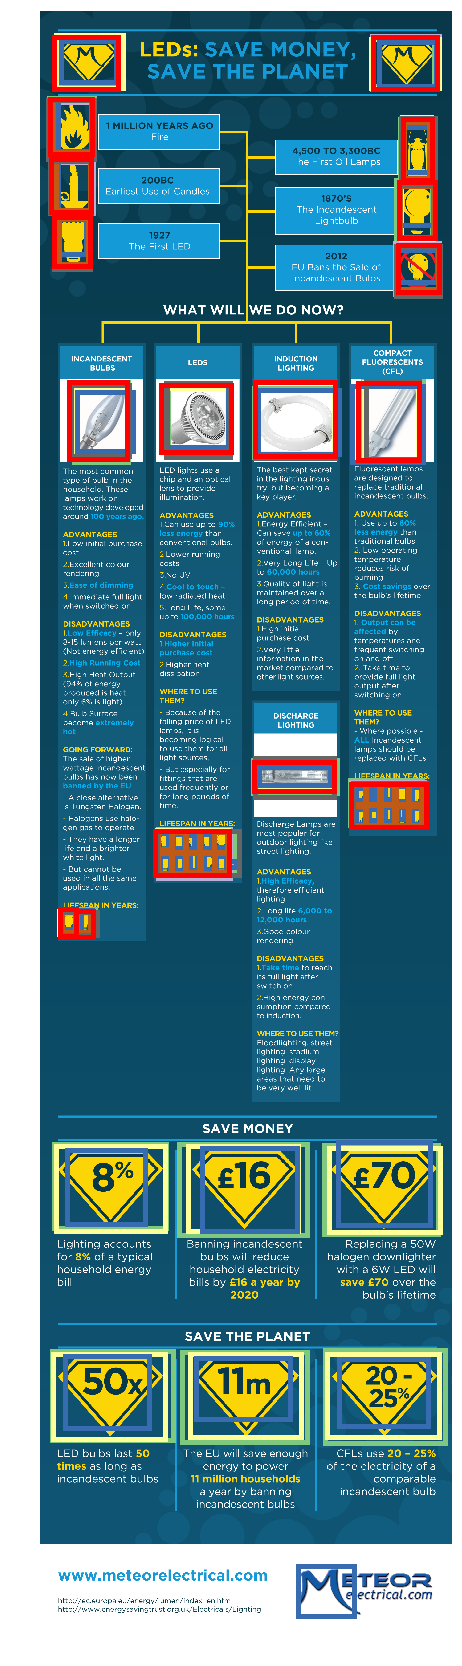

In [5]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# pick an infographic to display
filenames = [key for key in BOX_DICT.keys()]
imfile = random.choice(filenames) # display the annotations for a randomly-selected infographic
im = Image.open(os.path.join(IMDIR,imfile))
w,h = im.size

fig = plt.figure(figsize=(50,30)); 
ax = fig.add_subplot(1,1,1)
ax.imshow(im); plt.axis('off'); 

# plot annotations of different users in different colors
cmap = get_cmap(len(BOX_DICT[imfile]),'Accent')
for userid in range(len(BOX_DICT[imfile])): # compare annotations of user userid to gold-standard annotations
    whichboxes = BOX_DICT[imfile][userid]
    for box in whichboxes:
        bottom = int(box['bottom']*h)
        top = int(box['top']*h)
        left = int(box['left']*w)
        right = int(box['right']*w)
        rect = patches.Rectangle((left, bottom), right-left, top-bottom, linewidth=5,\
                                 edgecolor=cmap(userid),facecolor='none')
        ax.add_patch(rect) 
        
# plot gold-standard annotations in red
whichboxes = GS_BOX_DICT[imfile]
for box in whichboxes:
    bottom = int(box['bottom']*h)
    top = int(box['top']*h)
    left = int(box['left']*w)
    right = int(box['right']*w)
    rect = patches.Rectangle((left, bottom), right-left, top-bottom, linewidth=5,\
                             edgecolor='r',facecolor='none')
    ax.add_patch(rect) 